In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import data

from keras import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.ops import expand_dims
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Rescaling, RandomFlip, RandomRotation

In [2]:
image_size = (227, 227)
batch_size = 128

train_ds, val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

classes = train_ds.class_names
input_shape = image_size + (3,)

Found 5544 files belonging to 12 classes.
Using 4436 files for training.
Using 1108 files for validation.


In [3]:
def one_hot_decode(one_hot):
    return np.argmax(one_hot, axis=-1)

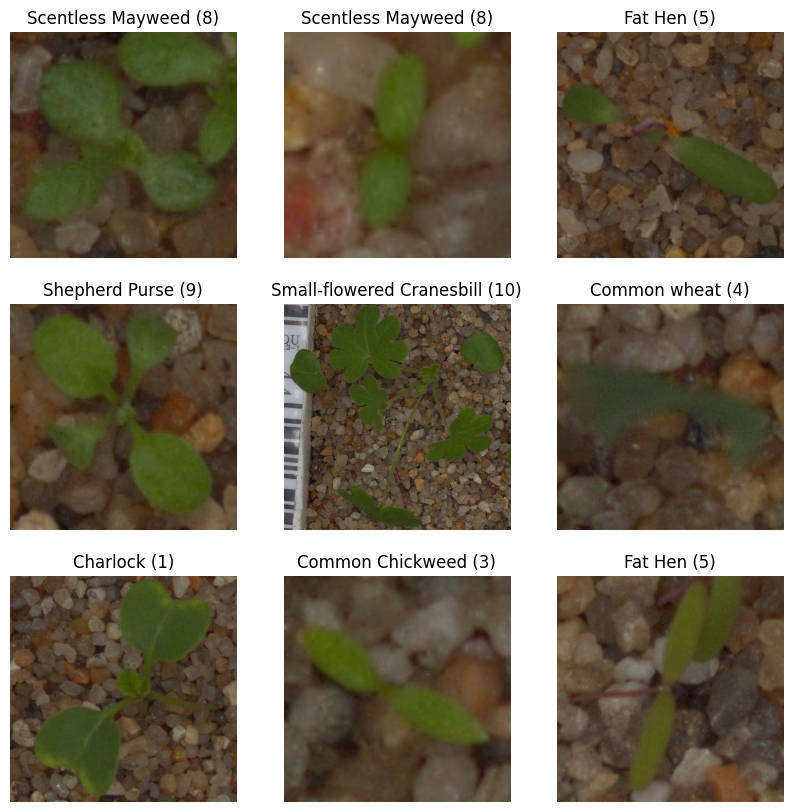

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        image = images[i].numpy().astype("uint8")
        label = one_hot_decode(labels[i])

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"{classes[label]} ({label})")
        plt.axis("off")

In [5]:
data_augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

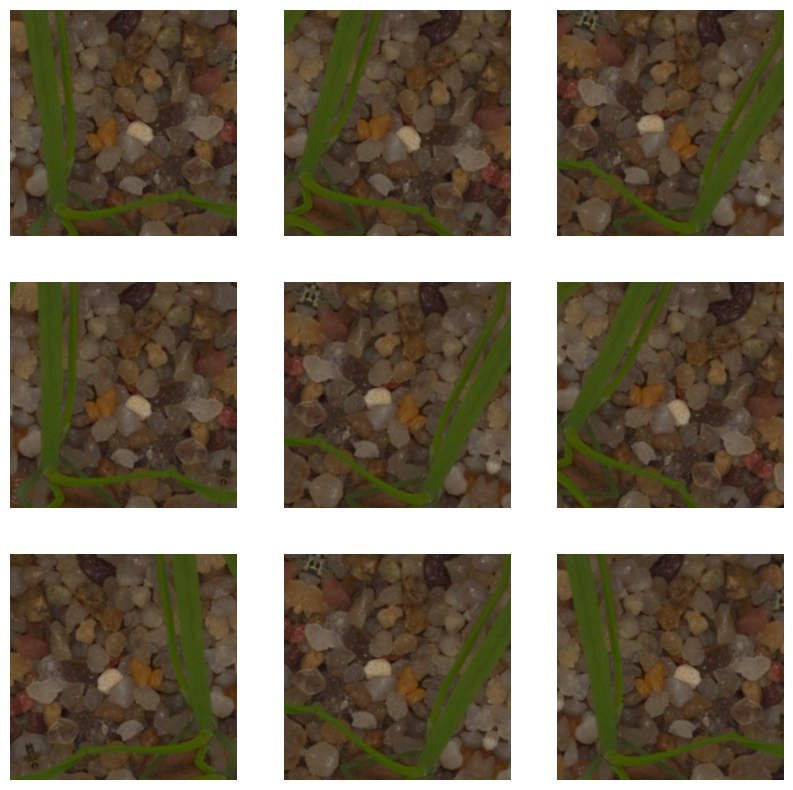

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(data.AUTOTUNE)
val_ds = val_ds.prefetch(data.AUTOTUNE)

In [8]:
model = Sequential()

model.add(Input(shape=input_shape))
model.add(Rescaling(1.0 / 255))

model.add(Conv2D(96, (11, 11), strides=4, activation="relu", name="conv1"))
model.add(BatchNormalization(axis=3, name="bn1"))

model.add(MaxPooling2D((3, 3), strides=2, name="maxpool1"))

model.add(Conv2D(256, (5, 5), padding="same", activation="relu", name="conv2"))
model.add(BatchNormalization(axis=3, name="bn2"))

model.add(MaxPooling2D((3, 3), strides=2, name="maxpool2"))

model.add(Conv2D(384, (3, 3), padding="same", activation="relu", name="conv3"))
model.add(BatchNormalization(axis=3, name="bn3"))

model.add(Conv2D(384, (3, 3), padding="same", activation="relu", name="conv4"))
model.add(BatchNormalization(axis=3, name="bn4"))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu", name="conv5"))
model.add(BatchNormalization(axis=3, name="bn5"))

model.add(MaxPooling2D((3, 3), strides=2, name="maxpool5"))

model.add(Flatten(name="flatten"))

model.add(Dense(4096, activation="relu", name="fc6"))
model.add(Dense(4096, activation="relu", name="fc7"))
model.add(Dense(12, activation="softmax", name="fc8"))

In [9]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 55, 55, 96)     │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 27, 27, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 13, 13, 384)    │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 13, 13, 384)    │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 13, 13, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool5 (MaxPooling2D)         │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6 (Dense)                     │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc7 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc8 (Dense)                     │ (None, 12)             │        49,164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,336,012 (222.53 MB)

 Trainable params: 58,333,260 (222.52 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [ ]:
epochs = 10

model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.1773 - loss: 39.6006 - val_accuracy: 0.0415 - val_loss: 11.2146
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.4191 - loss: 1.7368 - val_accuracy: 0.1255 - val_loss: 7.2038
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.5538 - loss: 1.2563 - val_accuracy: 0.1372 - val_loss: 8.1880
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.6282 - loss: 1.0388 - val_accuracy: 0.1381 - val_loss: 13.8732
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.6481 - loss: 0.9794 - val_accuracy: 0.1381 - val_loss: 14.4020
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6945 - loss: 0.8610 - val_accuracy: 0.1381 - val_loss: 13.3737
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7386 - loss: 0.7192

In [ ]:
img = load_img("PetImages/Cat/10198.jpg", target_size=image_size)
plt.imshow(img)

img_array = img_to_array(img)
img_array = expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)